# Description


- **과제 주요 목표**: 주어진 Dataset을 통해 2020년 1월의 일자별 NetSales와 Amount를 예측합니다.

- 과제 세부 목표
  - 시계열 데이터 분석 방법론에 대한 이해를 목표로 합니다.
  - 대표적인 시계열 분석 모델인 ARIMA 모델과 딥러닝 모델 중 하나인 LSTM 모델을 활용하여 예측을 진행합니다.
  - Matplotlib와 Seaborn 라이브러리를 통하여 적절한 시각화를 진행합니다. 

<br>

- Dataset에 대한 Column Description<br>

|Columns|Description|Detail|Category|
|---|---|---|---|
|Date|일자|-|범주형|
|Sales|매출액|판매가*수량|연속형|
|NetSales|순매출액|(판매가*수량) * 할인률|연속형|
|MeanSales|평균매출액|해당 일자의 (판매가*수량)/수량|연속형|
|Amount|판매수량|-|연속형|
|Stores|제품 판매 매장 수|-|연속형|
|SKU|제품 타입 개수|판매가 발생한 수|연속형|
> 같은 제품이더라도 SKU에 따라 조금씩 상이한 가격<br>
> 평균매출액은 단위별 다른 가격에 대한 한 제품의 평균 소비자 가격


# Data Import

In [1]:
# Google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import basic library
import pandas as pd
import numpy as np 

from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_excel('/content/drive/MyDrive/Data/SalesData.xlsx')

In [4]:
# DataSet의 Columns Name 변경
df.columns = ['Date', 'Sales', 'NetSales', 'Amount', 'MeanSales', 'DiscountRate', 'Stores', 'SKU']
# 기본 Columns 변수 할당
dflst = ['Sales', 'NetSales', 'MeanSales', 'Amount', 'DiscountRate', 'Stores', 'SKU']
# DataFrame 출력 format 설정_ 과학적 표기법 사용X
pd.options.display.float_format = '{:.2f}'.format
df.head()

,Date,Sales,NetSales,Amount,MeanSales,DiscountRate,Stores,SKU
0,2017-06-01,2502000,2383400,18,139000.00,0.05,48,4
1,2017-06-02,6086000,5984800,45,135244.44,0.02,48,8
2,2017-06-03,12778000,12510600,92,138891.30,0.02,48,8
3,2017-06-04,10842000,10631400,78,139000.00,0.02,48,7
4,2017-06-05,5560000,5522100,41,135609.76,0.01,48,7


## `요일` 변수 생성 

In [6]:
df['Day'] = 'temp'
tlst = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
#2017/06/05 월요일 ~ 
for i in range(len(df)):
  df['Day'][i+4] = tlst[i%7]
# 2017/06/01 목요일 ~ 2017/06/04 일요일
for i in range(4):
  df['Day'][i] = tlst[i+3]

df.head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Date,Sales,NetSales,Amount,MeanSales,DiscountRate,Stores,SKU,Day
0,2017-06-01,2502000,2383400,18,139000.00,0.05,48,4,Thur
1,2017-06-02,6086000,5984800,45,135244.44,0.02,48,8,Fri
2,2017-06-03,12778000,12510600,92,138891.30,0.02,48,8,Sat
3,2017-06-04,10842000,10631400,78,139000.00,0.02,48,7,Sun
4,2017-06-05,5560000,5522100,41,135609.76,0.01,48,7,Mon
5,2017-06-06,12371000,12113300,89,139000.00,0.02,48,7,Tue
6,2017-06-07,3967500,3801700,29,136810.34,0.04,48,8,Wed
7,2017-06-08,5282000,5282000,38,139000.00,0.00,48,8,Thur
8,2017-06-09,10147000,9702000,73,139000.00,0.04,48,7,Fri
9,2017-06-10,13344000,13080800,97,137567.01,0.02,48,9,Sat


# Data EDA

## 기술통계

- pandas의 Describe에 왜도와 첨도를 추가한 기술통계 확인

- Seaborn library를 이용하여 기초 EDA 진행
  1. distplot을 확인하여 Data 분포 시각화
  2. boxplot을 확인하여 Data의 분포 및 이상치 시각화

In [20]:
eda = df.describe()

# Describe에 추가할 Column 별 왜도 첨도
sklst = []
kulst =[]
for txt in dflst:
  sklst.append(df[txt].skew())
  kulst.append(df[txt].kurt())
skulst = [sklst, kulst]
skudf = pd.DataFrame(skulst, columns=eda.columns, index=['Skew','Kurt'])

eda = eda.append(skudf)
eda

,Sales,NetSales,Amount,MeanSales,DiscountRate,Stores,SKU
count,944.00,944.00,944.00,944.00,944.00,944.00,944.00
mean,8407918.43,7658885.36,57.44,147049.30,0.09,45.87,13.03
std,4959462.28,4504263.47,34.17,9739.52,0.08,5.94,4.42
min,219000.00,163400.00,1.00,124250.00,0.00,28.00,2.00
25%,4998750.00,4525550.00,34.00,139000.00,0.04,45.00,10.00
50%,7057500.00,6462550.00,48.00,144814.89,0.07,46.00,13.00
75%,10891250.00,10195725.00,75.00,152967.27,0.13,49.00,16.00
max,37391000.00,25800000.00,269.00,219000.00,0.65,56.00,30.00
Skew,1.21,1.02,1.57,1.26,2.21,-1.28,0.31
Kurt,1.83,0.76,5.57,2.20,8.26,2.23,-0.17


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

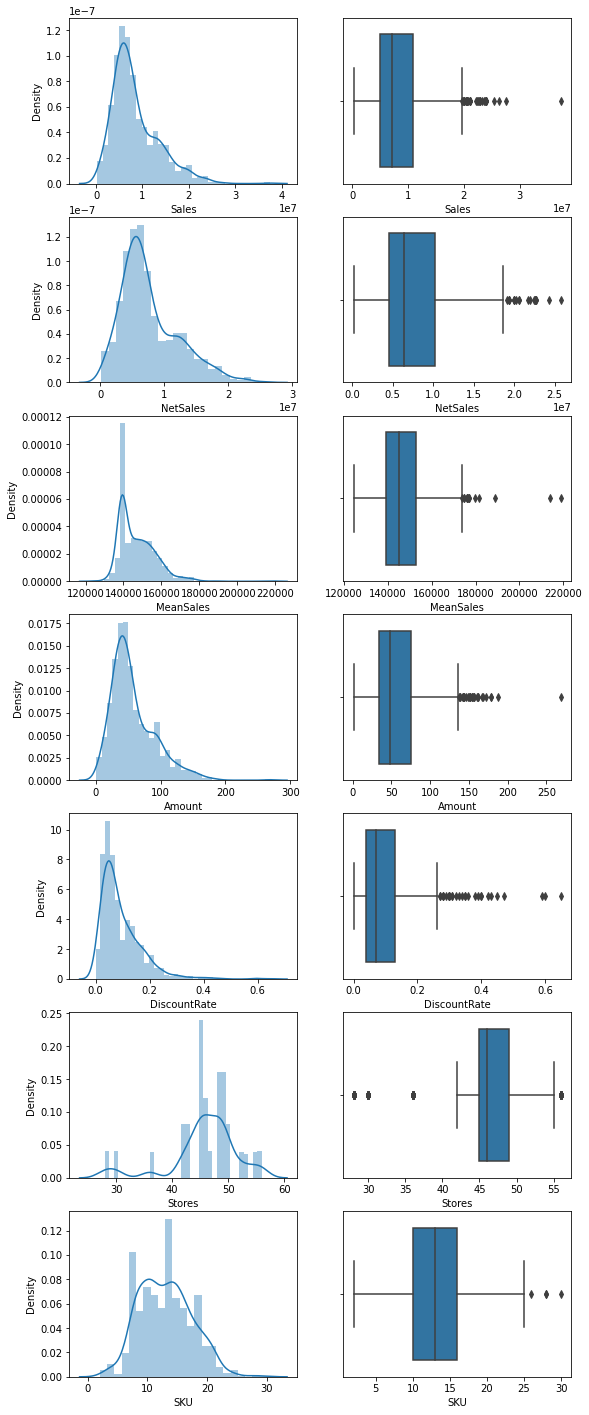

In [36]:
# Dataset 분포도 & Boxplot 
i=1
plt.figure(figsize=(9,25))
for txt in dflst:
  plt.subplot(7,2,i)
  sns.distplot(df[txt])
  i+=1
  plt.subplot(7,2,i)
  sns.boxplot(data=df, x= txt)
  i +=1

plt.show()

<h4>기초 기술통계를 통해 다음과 같은 사실을 유추</h4>

<br>


1. Sales보다 NetSales의 첨도가 낮고, 비교적 분포도의 꼬리가 짧은 것으로 보아 Sales보단 밀집도가 높은 NetSales를 토대로 예측하는 것이 용이할 것 같다.

2. Sales, NetSales, MeanSales, DiscountRate 모두 오른쪽으로 긴 꼬리를 가지고 있다. 이를 토대로 다음과 같은 가정을 세워볼 수 있다.
  - 할인기간, 잉여자본 생성시기 등 어떤 이유 때문에 고객들의 소비가 특정 기간에 집중된다.
  - 오른쪽의 긴 꼬리는 단순한 이상치일 뿐, 주요 판매 매출 데이터는 밀도가 높은 왼쪽의 데이터이다.



## 연도, 요일, 일자 별 판매 데이터 EDA

In [37]:
#Date column YY-MM-DD 분할 Column 생성
df['YY'] = 'temp'
df['MM'] = 'temp'
df['DD'] = 'temp'
for i in range(len(df)):
  tstr = df.iloc[i]['Date']
  [yy, mm, dd] = str(tstr).split("-")
  dd = dd.split(" ")[0]
  df['YY'].iloc[i] = yy
  df['MM'].iloc[i] = mm
  df['DD'].iloc[i] = dd

df = df[['Date', 'YY', 'MM', 'DD', 'Day', 'Sales', 'NetSales', 'Amount', 'MeanSales', 'DiscountRate', 'Stores', 'SKU']]
df.head(10)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Date,YY,MM,DD,Day,Sales,NetSales,Amount,MeanSales,DiscountRate,Stores,SKU
0,2017-06-01,2017,06,01,Thur,2502000,2383400,18,139000.00,0.05,48,4
1,2017-06-02,2017,06,02,Fri,6086000,5984800,45,135244.44,0.02,48,8
2,2017-06-03,2017,06,03,Sat,12778000,12510600,92,138891.30,0.02,48,8
3,2017-06-04,2017,06,04,Sun,10842000,10631400,78,139000.00,0.02,48,7
4,2017-06-05,2017,06,05,Mon,5560000,5522100,41,135609.76,0.01,48,7
5,2017-06-06,2017,06,06,Tue,12371000,12113300,89,139000.00,0.02,48,7
6,2017-06-07,2017,06,07,Wed,3967500,3801700,29,136810.34,0.04,48,8
7,2017-06-08,2017,06,08,Thur,5282000,5282000,38,139000.00,0.00,48,8
8,2017-06-09,2017,06,09,Fri,10147000,9702000,73,139000.00,0.04,48,7
9,2017-06-10,2017,06,10,Sat,13344000,13080800,97,137567.01,0.02,48,9


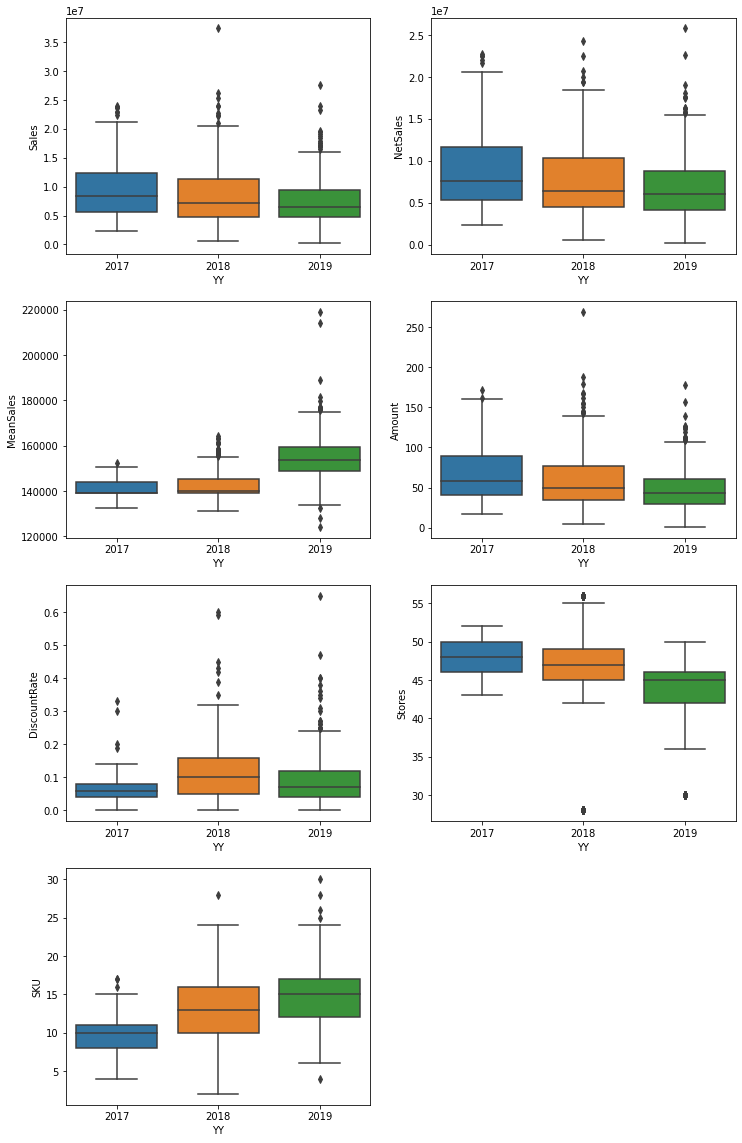

In [38]:
# 연도별, column별 데이터 분포 차이 확인
plt.figure(figsize=(12,20))
for i in range(len(dflst)):
  plt.subplot(4,2,i+1)
  sns.boxplot(data=df, x='YY', y=dflst[i])

plt.show()

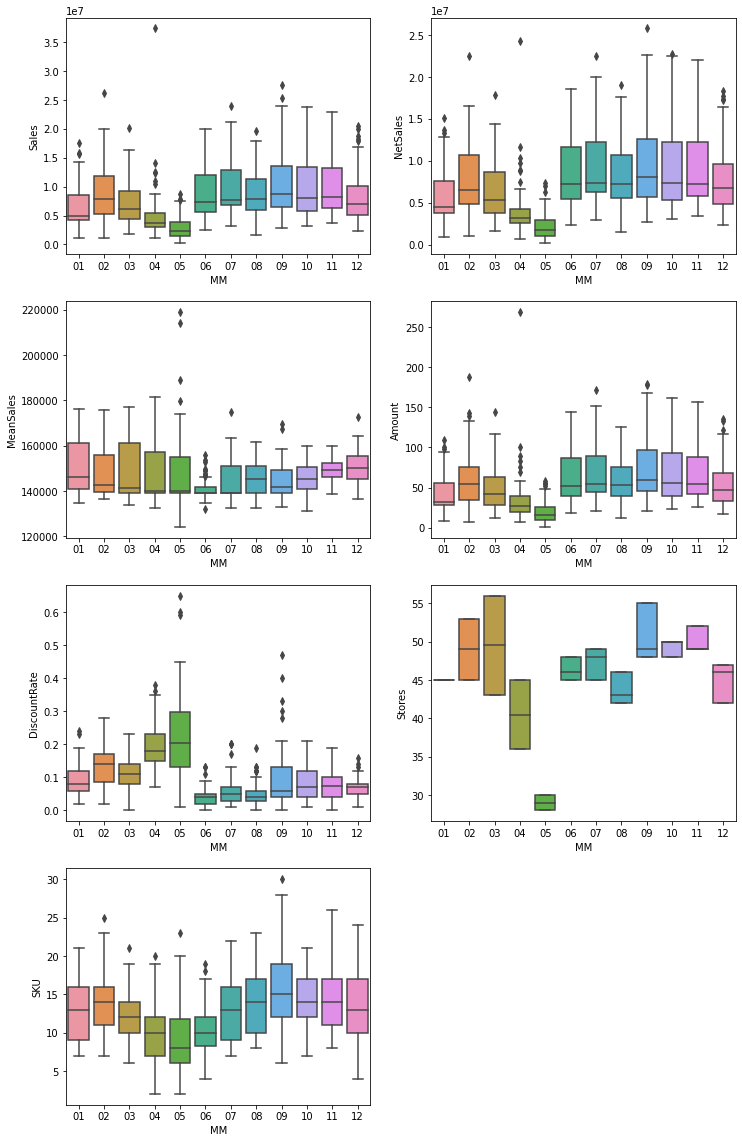

In [39]:
# 월별, column별 데이터 분포 차이 확인
plt.figure(figsize=(12, 20))
for i in range(len(dflst)):
  plt.subplot(4,2,i+1)
  sns.boxplot(data=df, y=dflst[i], x="MM", order=['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'])

plt.show()

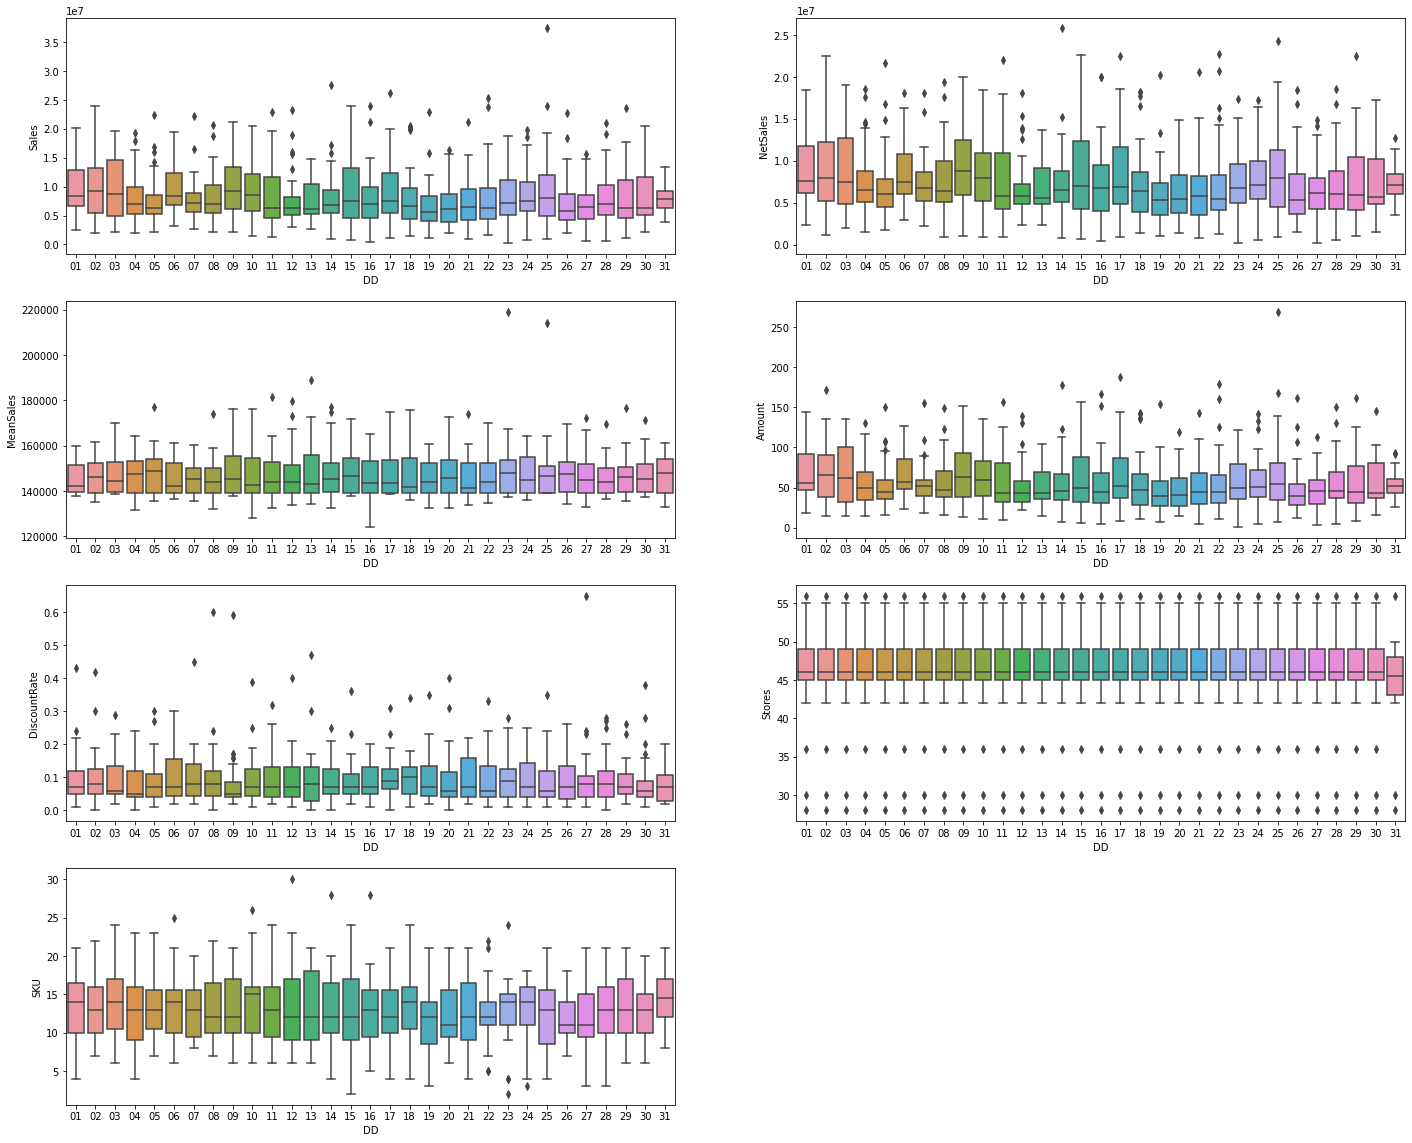

In [40]:
# 일자별, column별 데이터 분포 차이 확인
plt.figure(figsize=(24,20))
for i in range(len(dflst)):
  plt.subplot(4,2,i+1)
  sns.boxplot(data=df, y=dflst[i], x='DD')

plt.show()

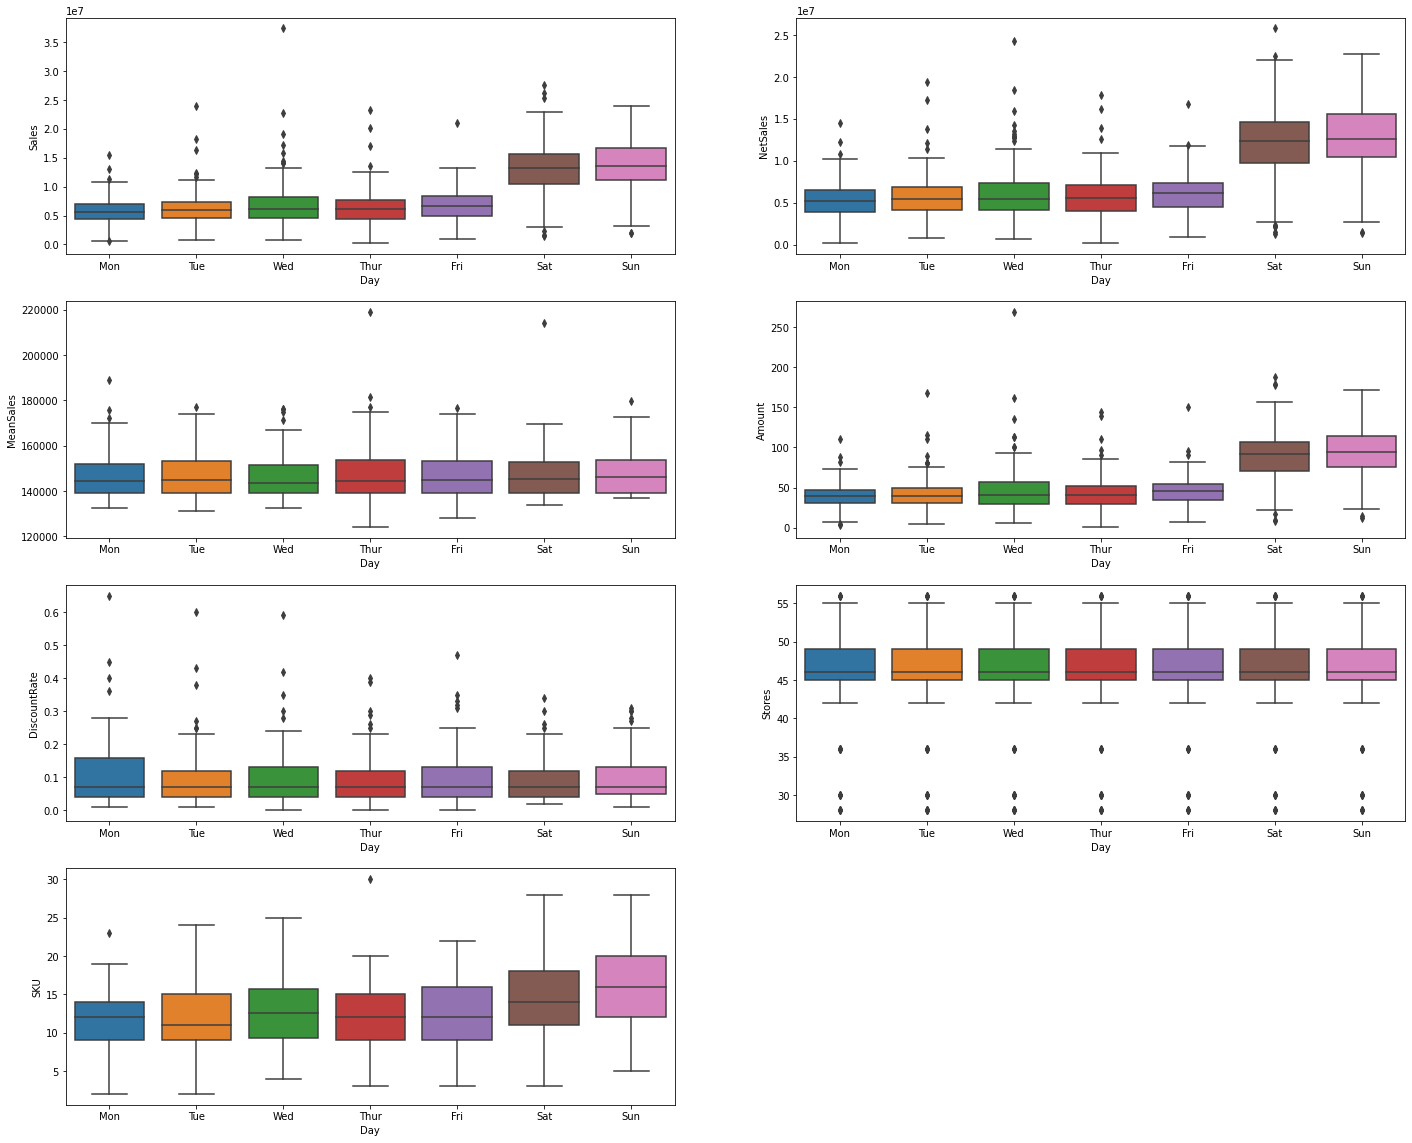

In [41]:
# 요일별, column별 데이터 분포 차이 확인
plt.figure(figsize=(24,20))
for i in range(len(dflst)):
  plt.subplot(4,2,i+1)
  sns.boxplot(data=df, y=dflst[i], x='Day', order=['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])

plt.show()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


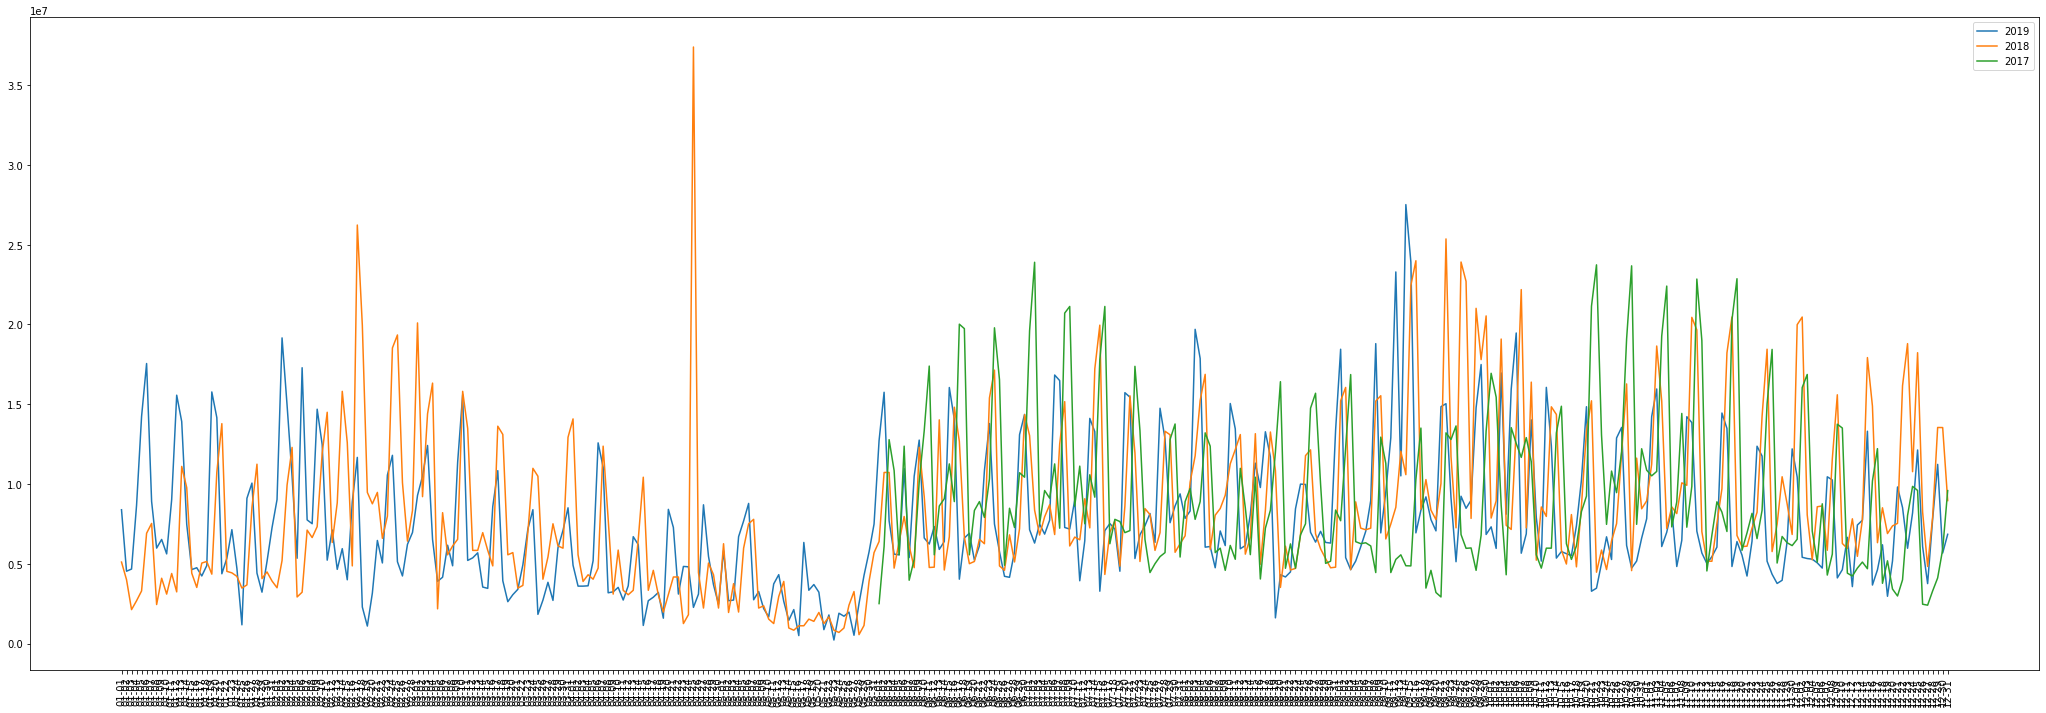

In [42]:
# 연도별 1년치 추세 그래프
# 월-일 형식의 데이터 생성
tmpdf = df.copy()
tmpdf['MMDD'] = 'temp'
for i in range(len(tmpdf)):
  tmpdf['MMDD'].iloc[i] = str(tmpdf.iloc[i]['MM'])+'-'+str(tmpdf.iloc[i]['DD'])
# 연도별 해당 날짜 매출 그래프
fig = plt.figure(figsize=(36,12))
ax = fig.add_subplot()

ax.plot(tmpdf.loc[tmpdf['YY']=='2019']['MMDD'], tmpdf.loc[df['YY']=='2019']['Sales'], label=2019)
ax.plot(tmpdf.loc[tmpdf['YY']=='2018']['MMDD'], tmpdf.loc[df['YY']=='2018']['Sales'], label=2018)
ax.plot(tmpdf.loc[tmpdf['YY']=='2017']['MMDD'], tmpdf.loc[df['YY']=='2017']['Sales'], label=2017)
plt.xticks(rotation = 90)
ax.legend()

plt.show()

- **연도별 데이터**
  1. 연도별 데이터를 boxplot으로 표현했을 시 `Sales`, `NetSales`, `Amount` 모두 근소하게 감소하고 있다.
  2. 반면 `MeanSales`는 꾸준하게 증가하고 있다.<br>
    -> 해당 제품에 대한 가격이 점차 증가하고 있다.
  3. 판매가 진행되는 `Store` 역시 감소 중에 있다.
  4. 손님들이 구매하는 한 제품 내 종류 수(`SKU`)가 증가하고 있다. <br>
    -> 손님들이 다양성을 선호한다.
> 증가하는 SKU를 바탕으로 손님들이 제품에 대한 다양성을 선호한다는 사실을 가정할 수 있고, 증가하는 MeanSales를 바탕으로 제품의 가격이 지속적으로 상승하고 있음을 유추해볼 수 있다.

<br>

- **월별 데이터**
  1. `Sales`, `NetSales`, `Amount` 모두 봄 기간(3월~5월) 기간 동안 가시적으로 감소하는 모습을 보인다.
  2. `DiscountRate`는 매출이 가장 적게 일어나는 봄 기간(3월~5월)이 가장 높다.
  3. 판매가 발생하는 `Store` 역시 봄 기간에 점차 줄어들다가 5월 달에 가시적으로 낮은 값을 보인다.
  4. 여름이 시작하며 증가세로 들어서는 다른 Column과는 달리 `MeanSales`는 6월이 가장 낮다

  > 가을 기간(9, 10, 11) 구매가 가장 많이 일어나고 봄을 제외한 여름과 겨울은 비슷한 매출을 보인다. 날씨에 영향을 많이 받지는 않지만, 환절기에 많이 사용하는 제품이라고 특성을 유추해볼 수 있다.

<br>

- **일자별&요일별 데이터**
  1. 일자별로 나누어봤을 때 크게 유의미한 인사이트는 없는 것 같다.
  2. 요일별로 나누어 봤을 때 평일과 주말의 가시적인 차이가 있고, 특히 평일 매출은 굉장히 중앙 밀집적이다. 반면 주말의 경우 다소 분포가 넓은 것을 확인할 수 있다.

  > 판매가 일어나는 매장에 따라 매출이 크게 영향을 받으며 평일과 주말에 대한 매출값이 크게 차이가 나는 것으로 보아 온라인 채널 데이터가 반영되지 않은 오프라인 채널 매출 데이터임을 유추할 수 있다. 또한 미래 매출 데이터를 예측하고자 할 때 평일과 주말이 가시적으로 차이가 나고, 분포가 중앙 밀집적인 것을 감안했을 때 요일 변수가 유의미할 수 있을 것 같다. 

# ARIMA

# LSTM

LSTM 모델을 이용하여 주어진 Dataset의 다음 달인 2020.01의 일자별 데이터를 예측해본다. 

- 예측 대상: `NetSales`, `Amount`
- 사용 변수: `NetSales`, `Amount`, `요일`
- 예측 방법: 현재 시점을 기준으로 7일 전까지, 총 7일동안의 데이터를 활용하여 30일 뒤 매출을 예측
- 예측 방법 선택 이유
  - 주어진 Dataset의 기간이 다소 짧아 충분한 학습에 대한 우려가 있다.
  - 31일 간의 데이터를 예측할 때 예측 주기가 짧아지면, 예측을 반복할수록 x_data에 학습된 예측값이 반복적으로 포함되어 오차가 증가하게 된다. 
  - 이를 방지하고자 최대한 가지고 있는 Dataset 안에서 해결하고자 30일 뒤를 예측하는 모델로 설정

In [51]:
#import library
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.metrics import mean_squared_error 

## Data Preprocessing

In [52]:
tempdf = df.copy()
tempdf.head()

,Date,YY,MM,DD,Day,Sales,NetSales,Amount,MeanSales,DiscountRate,Stores,SKU
0,2017-06-01,2017,06,01,Thur,2502000,2383400,18,139000.00,0.05,48,4
1,2017-06-02,2017,06,02,Fri,6086000,5984800,45,135244.44,0.02,48,8
2,2017-06-03,2017,06,03,Sat,12778000,12510600,92,138891.30,0.02,48,8
3,2017-06-04,2017,06,04,Sun,10842000,10631400,78,139000.00,0.02,48,7
4,2017-06-05,2017,06,05,Mon,5560000,5522100,41,135609.76,0.01,48,7


In [53]:
num = 37 # 30일 뒤 예측 + 7일간의 학습 데이터

for i in range(num):
  tempdf['Date_{}'.format(i)] = tempdf['Date'].shift(i)
  tempdf['Net_{}'.format(i)] = tempdf['NetSales'].shift(i)
  tempdf['Amt_{}'.format(i)] = tempdf['Amount'].shift(i)
  
tempdf = tempdf.dropna()

netlst = ['Net_%d' %(i) for i in range(num-7,num)]
amtlst = ['Amt_%d' %(i) for i in range(num-7,num)]
datelst = ['Date_%d' %(i) for i in range(num-7,num)]

tempdf = tempdf[['Date','Day', 'NetSales', 'Amount']+netlst+amtlst+datelst]
tempdf.index = [i for i in range(len(tempdf))]



tempdf

,Date,Day,NetSales,Amount,Net_30,Net_31,Net_32,Net_33,Net_34,Net_35,Net_36,Amt_30,Amt_31,Amt_32,Amt_33,Amt_34,Amt_35,Amt_36,Date_30,Date_31,Date_32,Date_33,Date_34,Date_35,Date_36
0,2017-07-07,Fri,6710700,52,3801700.00,12113300.00,5522100.00,10631400.00,12510600.00,5984800.00,2383400.00,29.00,89.00,41.00,78.00,92.00,45.00,18.00,2017-06-07,2017-06-06,2017-06-05,2017-06-04,2017-06-03,2017-06-02,2017-06-01
1,2017-07-08,Sat,19366200,149,5282000.00,3801700.00,12113300.00,5522100.00,10631400.00,12510600.00,5984800.00,38.00,29.00,89.00,41.00,78.00,92.00,45.00,2017-06-08,2017-06-07,2017-06-06,2017-06-05,2017-06-04,2017-06-03,2017-06-02
2,2017-07-09,Sun,19945300,152,9702000.00,5282000.00,3801700.00,12113300.00,5522100.00,10631400.00,12510600.00,73.00,38.00,29.00,89.00,41.00,78.00,92.00,2017-06-09,2017-06-08,2017-06-07,2017-06-06,2017-06-05,2017-06-04,2017-06-03
3,2017-07-10,Mon,8032500,62,13080800.00,9702000.00,5282000.00,3801700.00,12113300.00,5522100.00,10631400.00,97.00,73.00,38.00,29.00,89.00,41.00,78.00,2017-06-10,2017-06-09,2017-06-08,2017-06-07,2017-06-06,2017-06-05,2017-06-04
4,2017-07-11,Tue,10302900,80,16889300.00,13080800.00,9702000.00,5282000.00,3801700.00,12113300.00,5522100.00,125.00,97.00,73.00,38.00,29.00,89.00,41.00,2017-06-11,2017-06-10,2017-06-09,2017-06-08,2017-06-07,2017-06-06,2017-06-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903,2019-12-27,Fri,3432600,25,3407800.00,4063900.00,4838000.00,11124100.00,11830700.00,6067500.00,3958500.00,26.00,29.00,36.00,80.00,84.00,44.00,30.00,2019-11-27,2019-11-26,2019-11-25,2019-11-24,2019-11-23,2019-11-22,2019-11-21
904,2019-12-28,Sat,7174700,52,3976600.00,3407800.00,4063900.00,4838000.00,11124100.00,11830700.00,6067500.00,26.00,26.00,29.00,36.00,80.00,84.00,44.00,2019-11-28,2019-11-27,2019-11-26,2019-11-25,2019-11-24,2019-11-23,2019-11-22
905,2019-12-29,Sun,10488900,75,5861800.00,3976600.00,3407800.00,4063900.00,4838000.00,11124100.00,11830700.00,41.00,26.00,26.00,29.00,36.00,80.00,84.00,2019-11-29,2019-11-28,2019-11-27,2019-11-26,2019-11-25,2019-11-24,2019-11-23
906,2019-12-30,Mon,5313000,38,11402500.00,5861800.00,3976600.00,3407800.00,4063900.00,4838000.00,11124100.00,80.00,41.00,26.00,26.00,29.00,36.00,80.00,2019-11-30,2019-11-29,2019-11-28,2019-11-27,2019-11-26,2019-11-25,2019-11-24


In [54]:
daydf = pd.get_dummies(tempdf['Day'])[tlst]
daydf

,Mon,Tue,Wed,Thur,Fri,Sat,Sun
0,0,0,0,0,1,0,0
1,0,0,0,0,0,1,0
2,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0
4,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
903,0,0,0,0,1,0,0
904,0,0,0,0,0,1,0
905,0,0,0,0,0,0,1
906,1,0,0,0,0,0,0


In [55]:
# 정규화 & 표준화 Scaler for xdata(NetSales, Amount)
x_mn_scaler = MinMaxScaler()
x_std_scaler = StandardScaler()

# x_data scaler
x_data = x_mn_scaler.fit_transform(tempdf[netlst+amtlst])
x_data = x_std_scaler.fit_transform(x_data)
x_data = pd.DataFrame(x_data)
x_data.columns = ['Net_%d' %(i) for i in range(1,8)]+['Amt_%d' %(i) for i in range(1,8)]
# x_data_scale + day dummies
x_data = pd.concat([x_data, daydf],axis=1)
x_data

,Net_1,Net_2,Net_3,Net_4,Net_5,Net_6,Net_7,Amt_1,Amt_2,Amt_3,Amt_4,Amt_5,Amt_6,Amt_7,Mon,Tue,Wed,Thur,Fri,Sat,Sun
0,-0.86,0.97,-0.48,0.64,1.05,-0.38,-1.17,-0.84,0.90,-0.49,0.58,0.99,-0.38,-1.16,0,0,0,0,1,0,0
1,-0.53,-0.86,0.97,-0.48,0.64,1.05,-0.38,-0.58,-0.84,0.90,-0.49,0.58,0.99,-0.38,0,0,0,0,0,1,0
2,0.44,-0.53,-0.86,0.97,-0.48,0.64,1.05,0.44,-0.58,-0.84,0.90,-0.49,0.58,0.99,0,0,0,0,0,0,1
3,1.18,0.44,-0.53,-0.86,0.97,-0.48,0.64,1.13,0.44,-0.57,-0.84,0.90,-0.49,0.58,1,0,0,0,0,0,0
4,2.02,1.18,0.44,-0.53,-0.86,0.97,-0.48,1.95,1.13,0.44,-0.58,-0.84,0.90,-0.49,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
903,-0.94,-0.80,-0.63,0.75,0.90,-0.36,-0.82,-0.92,-0.84,-0.63,0.64,0.75,-0.40,-0.81,0,0,0,0,1,0,0
904,-0.82,-0.94,-0.80,-0.63,0.75,0.90,-0.36,-0.92,-0.92,-0.84,-0.63,0.64,0.75,-0.40,0,0,0,0,0,1,0
905,-0.40,-0.82,-0.94,-0.80,-0.63,0.75,0.90,-0.49,-0.92,-0.92,-0.84,-0.64,0.64,0.75,0,0,0,0,0,0,1
906,0.81,-0.40,-0.82,-0.94,-0.80,-0.63,0.75,0.64,-0.49,-0.92,-0.92,-0.84,-0.64,0.64,1,0,0,0,0,0,0


In [56]:
net_mn_scaler = MinMaxScaler()
net_std_scaler = StandardScaler()
amt_mn_scaler = MinMaxScaler()
amt_std_scaler = StandardScaler()

# y1(NetSale) scaler
tnp = np.array(tempdf['NetSales']).reshape(-1,1)
y1_data = net_mn_scaler.fit_transform(tnp)
y1_data = net_std_scaler.fit_transform(y1_data)

#y2(Amount) scaler
tnp=np.array(tempdf['Amount']).reshape(-1,1)
y2_data = amt_mn_scaler.fit_transform(tnp)
y2_data = amt_std_scaler.fit_transform(y2_data)



In [57]:
# split train/test set
#train set
x_train = x_data[:-30]
y1_train = y1_data[:-30]
y2_train = y2_data[:-30]
#test set
x_test = x_data[-30:]
y1_test = y1_data[-30:]
y2_test = y2_data[-30:]


In [58]:
# x_data reshape for LSTM Model
x_train_np = np.array(x_train).reshape(len(x_train), 3, 7)
x_test_np = np.array(x_test).reshape(len(x_test),3, 7)

# y_data reshape for LSTM Model
y1_train_np = y1_train.reshape(len(y1_train),1,1)
# y1_test_np = y1_test.reshape(len(y1_test),1,1)

y2_train_np = y2_train.reshape(len(y2_train),1,1)
# y2_test_np = y2_test.reshape(len(y2_test),1,1)

## NetSales

In [59]:
net_model = tf.keras.models.Sequential()
net_model.add(LSTM(7, input_shape=(x_train_np.shape[1], x_train_np.shape[2])))
# net_model.add(Dense(7))
net_model.add(Dense(1))
net_model.compile(loss='mean_squared_error', optimizer='adam')

net_model.fit(x_train_np, y1_train_np, epochs=100, batch_size=1)

Epoch 1/100
878/878 [==============================] - 3s 2ms/step - loss: 1.0543
Epoch 2/100
878/878 [==============================] - 2s 2ms/step - loss: 0.7481
Epoch 3/100
878/878 [==============================] - 2s 2ms/step - loss: 0.5630
Epoch 4/100
878/878 [==============================] - 2s 2ms/step - loss: 0.6479
Epoch 5/100
878/878 [==============================] - 2s 2ms/step - loss: 0.5505
Epoch 6/100
878/878 [==============================] - 2s 2ms/step - loss: 0.6344
Epoch 7/100
878/878 [==============================] - 2s 2ms/step - loss: 0.5275
Epoch 8/100
878/878 [==============================] - 2s 2ms/step - loss: 0.5634
Epoch 9/100
878/878 [==============================] - 2s 2ms/step - loss: 0.5259
Epoch 10/100
878/878 [==============================] - 1s 2ms/step - loss: 0.5653
Epoch 11/100
878/878 [==============================] - 1s 2ms/step - loss: 0.4760
Epoch 12/100
878/878 [==============================] - 2s 2ms/step - loss: 0.5139
Epoch 13/100


In [60]:
pred_net = net_model.predict(x_test_np)
# rmse 산출
# real_amt = np.array(y_scale_test_amt).reshape(30,1)
MSE_net = mean_squared_error(y1_test, pred_net) 
np.sqrt(MSE_net)

0.5606738254427226

In [61]:
pd.concat([pd.DataFrame(pred_net), pd.DataFrame(y1_test)], axis=1)

,0,0
0,-0.50,-0.52
1,-0.13,-0.52
2,-0.22,-0.56
3,-0.18,-0.61
4,-0.20,-0.67
5,1.27,0.50
6,1.04,0.48
7,-0.34,-0.84
8,-0.26,-0.72
9,-0.35,-0.40


## Amout

In [62]:
amt_model = tf.keras.models.Sequential()
amt_model.add(LSTM(7, input_shape=(x_train_np.shape[1], x_train_np.shape[2])))
# amt_model.add(Dense(len(list(x_train_np))))
# amt_model.add(Dense(0.5*len(list(x_train_np))))
# amt_model.add(Dense(7))
amt_model.add(Dense(1))
amt_model.compile(loss='mean_squared_error', optimizer='adam')

amt_model.fit(x_train_np, y2_train_np, epochs=100, batch_size=1)

Epoch 1/100
878/878 [==============================] - 3s 2ms/step - loss: 1.0823
Epoch 2/100
878/878 [==============================] - 1s 2ms/step - loss: 0.6926
Epoch 3/100
878/878 [==============================] - 1s 2ms/step - loss: 0.6971
Epoch 4/100
878/878 [==============================] - 1s 2ms/step - loss: 0.6220
Epoch 5/100
878/878 [==============================] - 2s 2ms/step - loss: 0.6640
Epoch 6/100
878/878 [==============================] - 2s 2ms/step - loss: 0.5421
Epoch 7/100
878/878 [==============================] - 2s 2ms/step - loss: 0.6477
Epoch 8/100
878/878 [==============================] - 2s 2ms/step - loss: 0.6008
Epoch 9/100
878/878 [==============================] - 2s 2ms/step - loss: 0.5007
Epoch 10/100
878/878 [==============================] - 2s 2ms/step - loss: 0.5461
Epoch 11/100
878/878 [==============================] - 2s 2ms/step - loss: 0.5084
Epoch 12/100
878/878 [==============================] - 1s 2ms/step - loss: 0.6251
Epoch 13/100


In [63]:
pred_amt = amt_model.predict(x_test_np)
# rmse 산출
# real_amt = np.array(y_scale_test_amt).reshape(30,1)
MSE_amt = mean_squared_error(y2_test, pred_amt) 
np.sqrt(MSE_amt)

0.5683343702014361

In [64]:
pd.concat([pd.DataFrame(pred_amt), pd.DataFrame(y2_test)], axis=1)

,0,0
0,-0.47,-0.58
1,-0.28,-0.70
2,-0.20,-0.70
3,-0.29,-0.67
4,-0.12,-0.79
5,1.17,0.36
6,1.20,0.31
7,-0.40,-0.85
8,-0.35,-0.76
9,-0.45,-0.37


## Validation

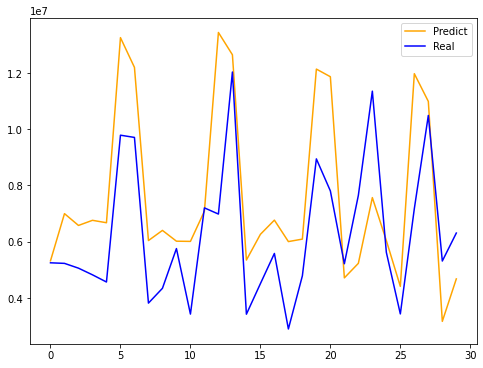

In [65]:
net_p = net_mn_scaler.inverse_transform(net_std_scaler.inverse_transform(pred_net))
net_r = net_mn_scaler.inverse_transform(net_std_scaler.inverse_transform(y1_test))

plt.figure(figsize=(8,6))
plt.plot(net_p, color='orange', label='Predict')
plt.plot(net_r, color='blue', label= 'Real')
plt.legend(loc='best')
plt.show()

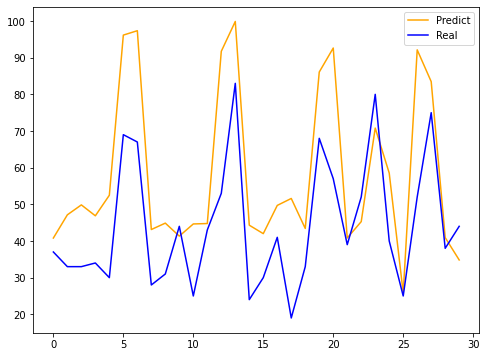

In [66]:
amt_p = amt_mn_scaler.inverse_transform(amt_std_scaler.inverse_transform(pred_amt))
amt_r = amt_mn_scaler.inverse_transform(amt_std_scaler.inverse_transform(y2_test))

plt.figure(figsize=(8,6))
plt.plot(amt_p, color='orange', label='Predict')
plt.plot(amt_r, color='blue', label= 'Real')
plt.legend(loc='best')
plt.show()

## Result

In [67]:
tdf = pd.DataFrame(df[['Date', 'Day', 'NetSales', 'Amount']][-36:])
for i in range(7):
  tdf['Date_{}'.format(i)] = tdf['Date'].shift(i)
  tdf['Net_{}'.format(i)] = tdf['NetSales'].shift(i)
  tdf['Amt_{}'.format(i)] = tdf['Amount'].shift(i)

tdf = tdf.dropna()

In [68]:
netlst2 = ['Net_%d' %(i) for i in range(7)]
amtlst2 = ['Amt_%d' %(i) for i in range(7)]
datelst2 = ['Date_%d' %(i) for i in range(7)]

tdf = tdf[['Day']+netlst2+amtlst2+datelst2]
tdf.index = [i for i in range(len(tdf))]
tdf.head()

,Day,Net_0,Net_1,Net_2,Net_3,Net_4,Net_5,Net_6,Amt_0,Amt_1,Amt_2,Amt_3,Amt_4,Amt_5,Amt_6,Date_0,Date_1,Date_2,Date_3,Date_4,Date_5,Date_6
0,Mon,5249700,9677500.00,11402500.00,5861800.00,3976600.00,3407800.00,4063900.00,37,68.00,80.00,41.00,26.00,26.00,29.00,2019-12-02,2019-12-01,2019-11-30,2019-11-29,2019-11-28,2019-11-27,2019-11-26
1,Tue,5229700,5249700.00,9677500.00,11402500.00,5861800.00,3976600.00,3407800.00,33,37.00,68.00,80.00,41.00,26.00,26.00,2019-12-03,2019-12-02,2019-12-01,2019-11-30,2019-11-29,2019-11-28,2019-11-27
2,Wed,5059400,5229700.00,5249700.00,9677500.00,11402500.00,5861800.00,3976600.00,33,33.00,37.00,68.00,80.00,41.00,26.00,2019-12-04,2019-12-03,2019-12-02,2019-12-01,2019-11-30,2019-11-29,2019-11-28
3,Thur,4822800,5059400.00,5229700.00,5249700.00,9677500.00,11402500.00,5861800.00,34,33.00,33.00,37.00,68.00,80.00,41.00,2019-12-05,2019-12-04,2019-12-03,2019-12-02,2019-12-01,2019-11-30,2019-11-29
4,Fri,4567100,4822800.00,5059400.00,5229700.00,5249700.00,9677500.00,11402500.00,30,34.00,33.00,33.00,37.00,68.00,80.00,2019-12-06,2019-12-05,2019-12-04,2019-12-03,2019-12-02,2019-12-01,2019-11-30
5,Sat,9787000,4567100.00,4822800.00,5059400.00,5229700.00,5249700.00,9677500.00,69,30.00,34.00,33.00,33.00,37.00,68.00,2019-12-07,2019-12-06,2019-12-05,2019-12-04,2019-12-03,2019-12-02,2019-12-01
6,Sun,9707700,9787000.00,4567100.00,4822800.00,5059400.00,5229700.00,5249700.00,67,69.00,30.00,34.00,33.00,33.00,37.00,2019-12-08,2019-12-07,2019-12-06,2019-12-05,2019-12-04,2019-12-03,2019-12-02
7,Mon,3817100,9707700.00,9787000.00,4567100.00,4822800.00,5059400.00,5229700.00,28,67.00,69.00,30.00,34.00,33.00,33.00,2019-12-09,2019-12-08,2019-12-07,2019-12-06,2019-12-05,2019-12-04,2019-12-03
8,Tue,4343000,3817100.00,9707700.00,9787000.00,4567100.00,4822800.00,5059400.00,31,28.00,67.00,69.00,30.00,34.00,33.00,2019-12-10,2019-12-09,2019-12-08,2019-12-07,2019-12-06,2019-12-05,2019-12-04
9,Wed,5756100,4343000.00,3817100.00,9707700.00,9787000.00,4567100.00,4822800.00,44,31.00,28.00,67.00,69.00,30.00,34.00,2019-12-11,2019-12-10,2019-12-09,2019-12-08,2019-12-07,2019-12-06,2019-12-05


In [69]:
# df['Day'] = 'temp'
tlst = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']

for i in range(len(df)):
  tdf['Day'][i+5] = tlst[i%7]

for i in range(5):
  tdf['Day'][i] = tlst[i+2]

tdf.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Day,Net_0,Net_1,Net_2,Net_3,Net_4,Net_5,Net_6,Amt_0,Amt_1,Amt_2,Amt_3,Amt_4,Amt_5,Amt_6,Date_0,Date_1,Date_2,Date_3,Date_4,Date_5,Date_6
0,Wed,5249700,9677500.00,11402500.00,5861800.00,3976600.00,3407800.00,4063900.00,37,68.00,80.00,41.00,26.00,26.00,29.00,2019-12-02,2019-12-01,2019-11-30,2019-11-29,2019-11-28,2019-11-27,2019-11-26
1,Thur,5229700,5249700.00,9677500.00,11402500.00,5861800.00,3976600.00,3407800.00,33,37.00,68.00,80.00,41.00,26.00,26.00,2019-12-03,2019-12-02,2019-12-01,2019-11-30,2019-11-29,2019-11-28,2019-11-27
2,Fri,5059400,5229700.00,5249700.00,9677500.00,11402500.00,5861800.00,3976600.00,33,33.00,37.00,68.00,80.00,41.00,26.00,2019-12-04,2019-12-03,2019-12-02,2019-12-01,2019-11-30,2019-11-29,2019-11-28
3,Sat,4822800,5059400.00,5229700.00,5249700.00,9677500.00,11402500.00,5861800.00,34,33.00,33.00,37.00,68.00,80.00,41.00,2019-12-05,2019-12-04,2019-12-03,2019-12-02,2019-12-01,2019-11-30,2019-11-29
4,Sun,4567100,4822800.00,5059400.00,5229700.00,5249700.00,9677500.00,11402500.00,30,34.00,33.00,33.00,37.00,68.00,80.00,2019-12-06,2019-12-05,2019-12-04,2019-12-03,2019-12-02,2019-12-01,2019-11-30
5,Mon,9787000,4567100.00,4822800.00,5059400.00,5229700.00,5249700.00,9677500.00,69,30.00,34.00,33.00,33.00,37.00,68.00,2019-12-07,2019-12-06,2019-12-05,2019-12-04,2019-12-03,2019-12-02,2019-12-01
6,Tue,9707700,9787000.00,4567100.00,4822800.00,5059400.00,5229700.00,5249700.00,67,69.00,30.00,34.00,33.00,33.00,37.00,2019-12-08,2019-12-07,2019-12-06,2019-12-05,2019-12-04,2019-12-03,2019-12-02
7,Wed,3817100,9707700.00,9787000.00,4567100.00,4822800.00,5059400.00,5229700.00,28,67.00,69.00,30.00,34.00,33.00,33.00,2019-12-09,2019-12-08,2019-12-07,2019-12-06,2019-12-05,2019-12-04,2019-12-03
8,Thur,4343000,3817100.00,9707700.00,9787000.00,4567100.00,4822800.00,5059400.00,31,28.00,67.00,69.00,30.00,34.00,33.00,2019-12-10,2019-12-09,2019-12-08,2019-12-07,2019-12-06,2019-12-05,2019-12-04
9,Fri,5756100,4343000.00,3817100.00,9707700.00,9787000.00,4567100.00,4822800.00,44,31.00,28.00,67.00,69.00,30.00,34.00,2019-12-11,2019-12-10,2019-12-09,2019-12-08,2019-12-07,2019-12-06,2019-12-05


In [70]:
fin_day = pd.get_dummies(tdf['Day'])[tlst]
fin_day.head()

,Mon,Tue,Wed,Thur,Fri,Sat,Sun
0,0,0,1,0,0,0,0
1,0,0,0,1,0,0,0
2,0,0,0,0,1,0,0
3,0,0,0,0,0,1,0
4,0,0,0,0,0,0,1
5,1,0,0,0,0,0,0
6,0,1,0,0,0,0,0
7,0,0,1,0,0,0,0
8,0,0,0,1,0,0,0
9,0,0,0,0,1,0,0


In [71]:
ttdf = tdf[netlst2+amtlst2]
fin_x = x_std_scaler.transform(x_mn_scaler.transform(ttdf))
fin_x = pd.concat([pd.DataFrame(fin_x), fin_day], axis=1)
fin_x = np.array(fin_x).reshape(len(fin_x), 3, 7)
fin_x[0]

array([[-0.53854926,  0.43353472,  0.81400201, -0.40425562, -0.82019656,
        -0.94611458, -0.80125271],
       [-0.60417456,  0.2931319 ,  0.64194696, -0.48872107, -0.9251693 ,
        -0.92614031, -0.83858617],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ]])

In [72]:
fin_pred_net = net_model.predict(fin_x)
fin_pred_amt = amt_model.predict(fin_x)

In [89]:
result_net = pd.DataFrame(np.ceil(net_mn_scaler.inverse_transform(net_std_scaler.inverse_transform(fin_pred_net.reshape(30,1)))))
result_amt = pd.DataFrame(np.ceil(amt_mn_scaler.inverse_transform(amt_std_scaler.inverse_transform(fin_pred_amt.reshape(30,1)))))
result = pd.concat([result_net, result_amt], axis=1)
result.columns = ['Net', 'Amt']
result.tail()

,Net,Amt
25,9355740.00,101.00
26,4058488.00,33.00
27,4514564.00,31.00
28,7582181.00,57.00
29,6289746.00,42.00


In [74]:
tnet = [8483159, 6307600,	5313000.00,	10488900.00,	7174700.00,	3432600.00,	5622000.00]
tamt = [63, 44,	38.00,	75.00,	52.00,	25.00,	40.00]
last = pd.DataFrame(x_std_scaler.transform(x_mn_scaler.transform(pd.DataFrame(tnet+tamt).T)))

In [75]:
tla = [0,0,0,0,1,0,0]
tla = pd.DataFrame(tla).T
last = pd.concat([last, tla], axis=1)

lastx = np.array(last).reshape(1,3,7)
lastx

array([[[ 0.17188913, -0.30657576, -0.52371601,  0.61206708,
         -0.11791844, -0.94066644, -0.45910179],
        [ 0.14906546, -0.40188827, -0.57445417,  0.49592925,
         -0.17225135, -0.95511012, -0.52002995],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          1.        ,  0.        ,  0.        ]]])

In [90]:
last_pred_net = net_model.predict(lastx)
last_pred_amt = amt_model.predict(lastx)

last_net = np.ceil(net_mn_scaler.inverse_transform(net_std_scaler.inverse_transform(last_pred_net)))
last_amt = np.ceil(amt_mn_scaler.inverse_transform(amt_std_scaler.inverse_transform(last_pred_amt)))

tp = pd.DataFrame([int(last_net), int(last_amt)]).T
tp.columns = ['Net', 'Amt']
result = pd.concat([result, tp])
result.index = [i+1 for i in range(len(result))]
result

,Net,Amt
1,7345794.00,98.00
2,5947701.00,61.00
3,4542513.00,33.00
4,13436799.00,96.00
5,10954760.00,81.00
6,2719977.00,41.00
7,3974952.00,31.00
8,4213667.00,66.00
9,4985098.00,51.00
10,4231632.00,35.00
